In [1]:
%run Imports.ipynb
import numpy as np
import time
import warnings
import pandas as pd
import pickle

import quantpy as qp

from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

warnings.filterwarnings('ignore', category=np.ComplexWarning)

In [2]:
titlesize = 40
labelsize = 66
legendsize = 46
xticksize = 48
yticksize = xticksize
linewidth = 3
fontsize = 60
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize
matplotlib.rcParams['font.size'] = fontsize
matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

In [4]:
with open('../data/states.pkl', 'rb') as f:
    states = pickle.load(f)
states

,name,state,title,povm,n_meas
0,zero1,"Quantum object\narray([[1.+0.j, 0.+0.j],\n ...",$|0\rangle$,proj-set,1000
1,pure1,"Quantum object\narray([[0.85355+0.j , 0.25 ...",$\cos\frac{\pi}{8}|0\rangle + \sin\frac{\pi}{8...,proj-set,1000
2,fullymixed1,"Quantum object\narray([[0.5+0.j, 0. +0.j],\n ...",1-qubit fully mixed state,proj-set,1000
3,zero2,"Quantum object\narray([[1.+0.j, 0.+0.j, 0.+0.j...",$|00\rangle$,proj-set,10000
4,ghz2,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",$|\Phi^+\rangle$,proj-set,10000
5,fullymixed2,"Quantum object\narray([[0.25+0.j, 0. +0.j, 0....",2-qubit fully mixed state,proj-set,10000
6,ghz3,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",3-qubit GHZ state,proj-set,100000


In [5]:
with open('../data/processes.pkl', 'rb') as f:
    processes = pickle.load(f)
processes

,name,process,title,povm,n_meas
0,hadamard,Quantum channel with Choi matrix\narray([[ 0.5...,Hadamard gate,proj-set,1000
1,rxpi2,Quantum channel with Choi matrix\narray([[0.5+...,$RX(\pi/2)$,proj-set,1000
2,rypi2,Quantum channel with Choi matrix\narray([[ 0.5...,$RY(\pi/2)$,proj-set,1000
3,dep1,Quantum channel with Choi matrix\narray([[0.5+...,Fully depolarizing 1-qubit,proj-set,1000
4,cnot,Quantum channel with Choi matrix\narray([[1.+0...,CNOT,proj-set,100000
5,ms,Quantum channel with Choi matrix\narray([[ 0.5...,Mølmer–Sørensen gate,proj-set,100000


In [11]:
def get_state_verification(state: dict, n_points: int, conf_levels: list[int]):
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(state['n_meas'], povm='proj-set')
    interval = qp.MomentInterval(tmg, n_points=n_points)
    dist, CLs = interval(np.linspace(1e-3, 1-1e-3, n_points))
    state_hat = tmg.point_estimate(physical=False)
    distance_hat = qp.hs_dst(state_hat, state['state'])
    return [distance_hat < dist[int(cl * N_POINTS)] for cl in conf_levels]


def get_process_verification(process: dict, n_points: int, conf_levels: list[int]):
    tmg = qp.ProcessTomograph(process['process'])
    tmg.experiment(process['n_meas'], povm=process['povm'])
    interval = qp.MomentInterval(tmg, n_points=N_POINTS)
    dist, CLs = interval(np.linspace(1e-3, 1-1e-3, n_points))
    process_hat = tmg.point_estimate(cptp=False)
    distance_hat = qp.hs_dst(process_hat.choi, process['process'].choi)
    return [distance_hat < dist[int(cl * N_POINTS)] for cl in conf_levels]

In [ ]:
N_REPEATS = 10000
N_POINTS = 10000
CONFIDENCE_LEVELS = [0.5, 0.75, 0.9, 0.95, 0.99]

states_results = defaultdict(list)

for _, state in list(states.iterrows()):
    results = Parallel(n_jobs=-2)(
        delayed(get_state_verification)(state, n_points=N_POINTS, conf_levels=CONFIDENCE_LEVELS) 
        for i in tqdm(range(N_REPEATS))
    )
    results = np.asarray(results).sum(axis=0) / N_REPEATS
    states_results['name'].append(state['name'])
    for cl, freq in zip(CONFIDENCE_LEVELS, results):
        states_results[cl].append(freq)
        
pd.DataFrame(states_results)

In [ ]:
N_REPEATS = 10000
N_POINTS = 10000
CONFIDENCE_LEVELS = [0.5, 0.75, 0.9, 0.95, 0.99]

processes_results = defaultdict(list)

for _, process in list(processes.iterrows())[:5]:
    results = Parallel(n_jobs=-2)(
        delayed(get_process_verification)(process, n_points=N_POINTS, conf_levels=CONFIDENCE_LEVELS) 
        for i in tqdm(range(N_REPEATS))
    )
    results = np.asarray(results).sum(axis=0) / N_REPEATS
    processes_results['name'].append(process['name'])
    for cl, freq in zip(CONFIDENCE_LEVELS, results):
        processes_results[cl].append(freq)
        
pd.DataFrame(processes_results)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Stuff

In [5]:
N_REPEATS = 10000
N_POINTS = 10000
CONFIDENCE_LEVELS = [0.5, 0.75, 0.9, 0.95, 0.99]

def get_state_verification(state: dict, n_points: int, conf_levels: list[int]):
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(state['n_meas'], povm='proj-set')
    interval = qp.MomentInterval(tmg, n_points=n_points)
    dist, CLs = interval(np.linspace(1e-3, 1-1e-3, n_points))
    state_hat = tmg.point_estimate(physical=False)
    distance_hat = qp.hs_dst(state_hat, state['state'])
    return [distance_hat < dist[int(cl * N_POINTS)] for cl in conf_levels]

states_results = defaultdict(list)

for _, state in list(states.iterrows())[:-1]:
    results = Counter()
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.StateTomograph(state['state'])
        tmg.experiment(state['n_meas'], povm='proj-set')
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval(np.linspace(1e-3, 1-1e-3, N_POINTS))
        state_hat = tmg.point_estimate(physical=False)
        distance_hat = qp.hs_dst(state_hat, state['state'])
        for cl in CONFIDENCE_LEVELS:
            if distance_hat < dist[int(cl * N_POINTS)]:
                results[cl] += 1
    
    states_results['name'].append(state['name'])
    for key, value in results.items():
        states_results[key].append(value / N_REPEATS)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
pd.DataFrame(states_results)

,name,0.5,0.75,0.9,0.95,0.99
0,zero1,0.5096,0.7551,0.8998,0.9508,0.9905
1,pure1,0.4987,0.7472,0.8980,0.9504,0.9884
2,fullymixed1,0.5019,0.7499,0.9034,0.9507,0.9883
3,zero2,0.5031,0.7493,0.8955,0.9481,0.9881
4,ghz2,0.5062,0.7583,0.9008,0.9472,0.9871
5,fullymixed2,0.4984,0.7487,0.8970,0.9467,0.9883


In [7]:
pd.DataFrame(states_results)

,name,0.5,0.75,0.9,0.95,0.99
0,zero1,0.514,0.776,0.911,0.950,0.983
1,pure1,0.486,0.745,0.911,0.954,0.992
2,fullymixed1,0.522,0.767,0.909,0.950,0.991
3,zero2,0.502,0.745,0.897,0.951,0.992
4,ghz2,0.513,0.763,0.910,0.954,0.987
5,fullymixed2,0.493,0.744,0.893,0.945,0.989
6,ghz3,0.494,0.731,0.890,0.940,0.990


In [9]:
N_REPEATS = 1000
N_POINTS = 1000
CONFIDENCE_LEVELS = [0.5, 0.75, 0.9, 0.95, 0.99]

processes_results = defaultdict(list)

for _, process in list(processes.iterrows())[:5]:
    results = Counter()
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.ProcessTomograph(process['process'])
        tmg.experiment(process['n_meas'], povm=process['povm'])
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        process_hat = tmg.point_estimate(cptp=False)
        distance_hat = qp.hs_dst(process_hat.choi, process['process'].choi)
        for cl in CONFIDENCE_LEVELS:
            if distance_hat < dist[int(cl * N_POINTS)]:
                results[cl] += 1
    
    processes_results['name'].append(process['name'])
    for key, value in results.items():
        processes_results[key].append(value / N_REPEATS)

  0%|          | 0/1000 [00:00<?, ?it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
pd.DataFrame(processes_results)

,name,0.9,0.95,0.99,0.5,0.75
0,hadamard,0.890,0.938,0.988,0.496,0.744
1,rxpi2,0.905,0.960,0.991,0.503,0.752
2,rypi2,0.916,0.959,0.987,0.520,0.762
3,dep1,0.905,0.948,0.985,0.521,0.770
4,cnot,0.897,0.947,0.982,0.509,0.750


In [14]:
pd.DataFrame(processes_results)

,name,0.5,0.75,0.9,0.95,0.99
0,hadamard,0.508,0.770,0.922,0.961,0.992
1,rxpi2,0.510,0.746,0.892,0.948,0.989
2,rypi2,0.499,0.754,0.907,0.948,0.984
3,dep1,0.526,0.774,0.908,0.953,0.989


## Stuff

In [5]:
state = states.iloc[0]
tmg = qp.StateTomograph(state['state'])
tmg.experiment(state['n_meas'], povm=state['povm'])
interval = qp.MomentInterval(tmg, n_points=1000)
dist, CLs = interval()
state_hat = tmg.point_estimate(physical=False)
distance_hat = qp.hs_dst(state_hat, state['state'])

In [6]:
N_REPEATS = 1000
N_POINTS = 1000

states_results = defaultdict(list)

for i in range(len(states)):
    state = states.iloc[i]
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.StateTomograph(state['state'])
        tmg.experiment(state['n_meas'], povm='proj')
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        state_hat = tmg.point_estimate(physical=False)
        distance_hat = qp.hs_dst(state_hat, state['state'])
        ub_cls = np.where(distance_hat < dist)[0]
        epsilon = 1 - np.where(distance_hat < dist)[0][0] / N_POINTS if len(ub_cls) != 0 else 0
        states_results[state['name']].append(epsilon)
    states_results[state['name']].sort()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.02, 0.9, 'a)')

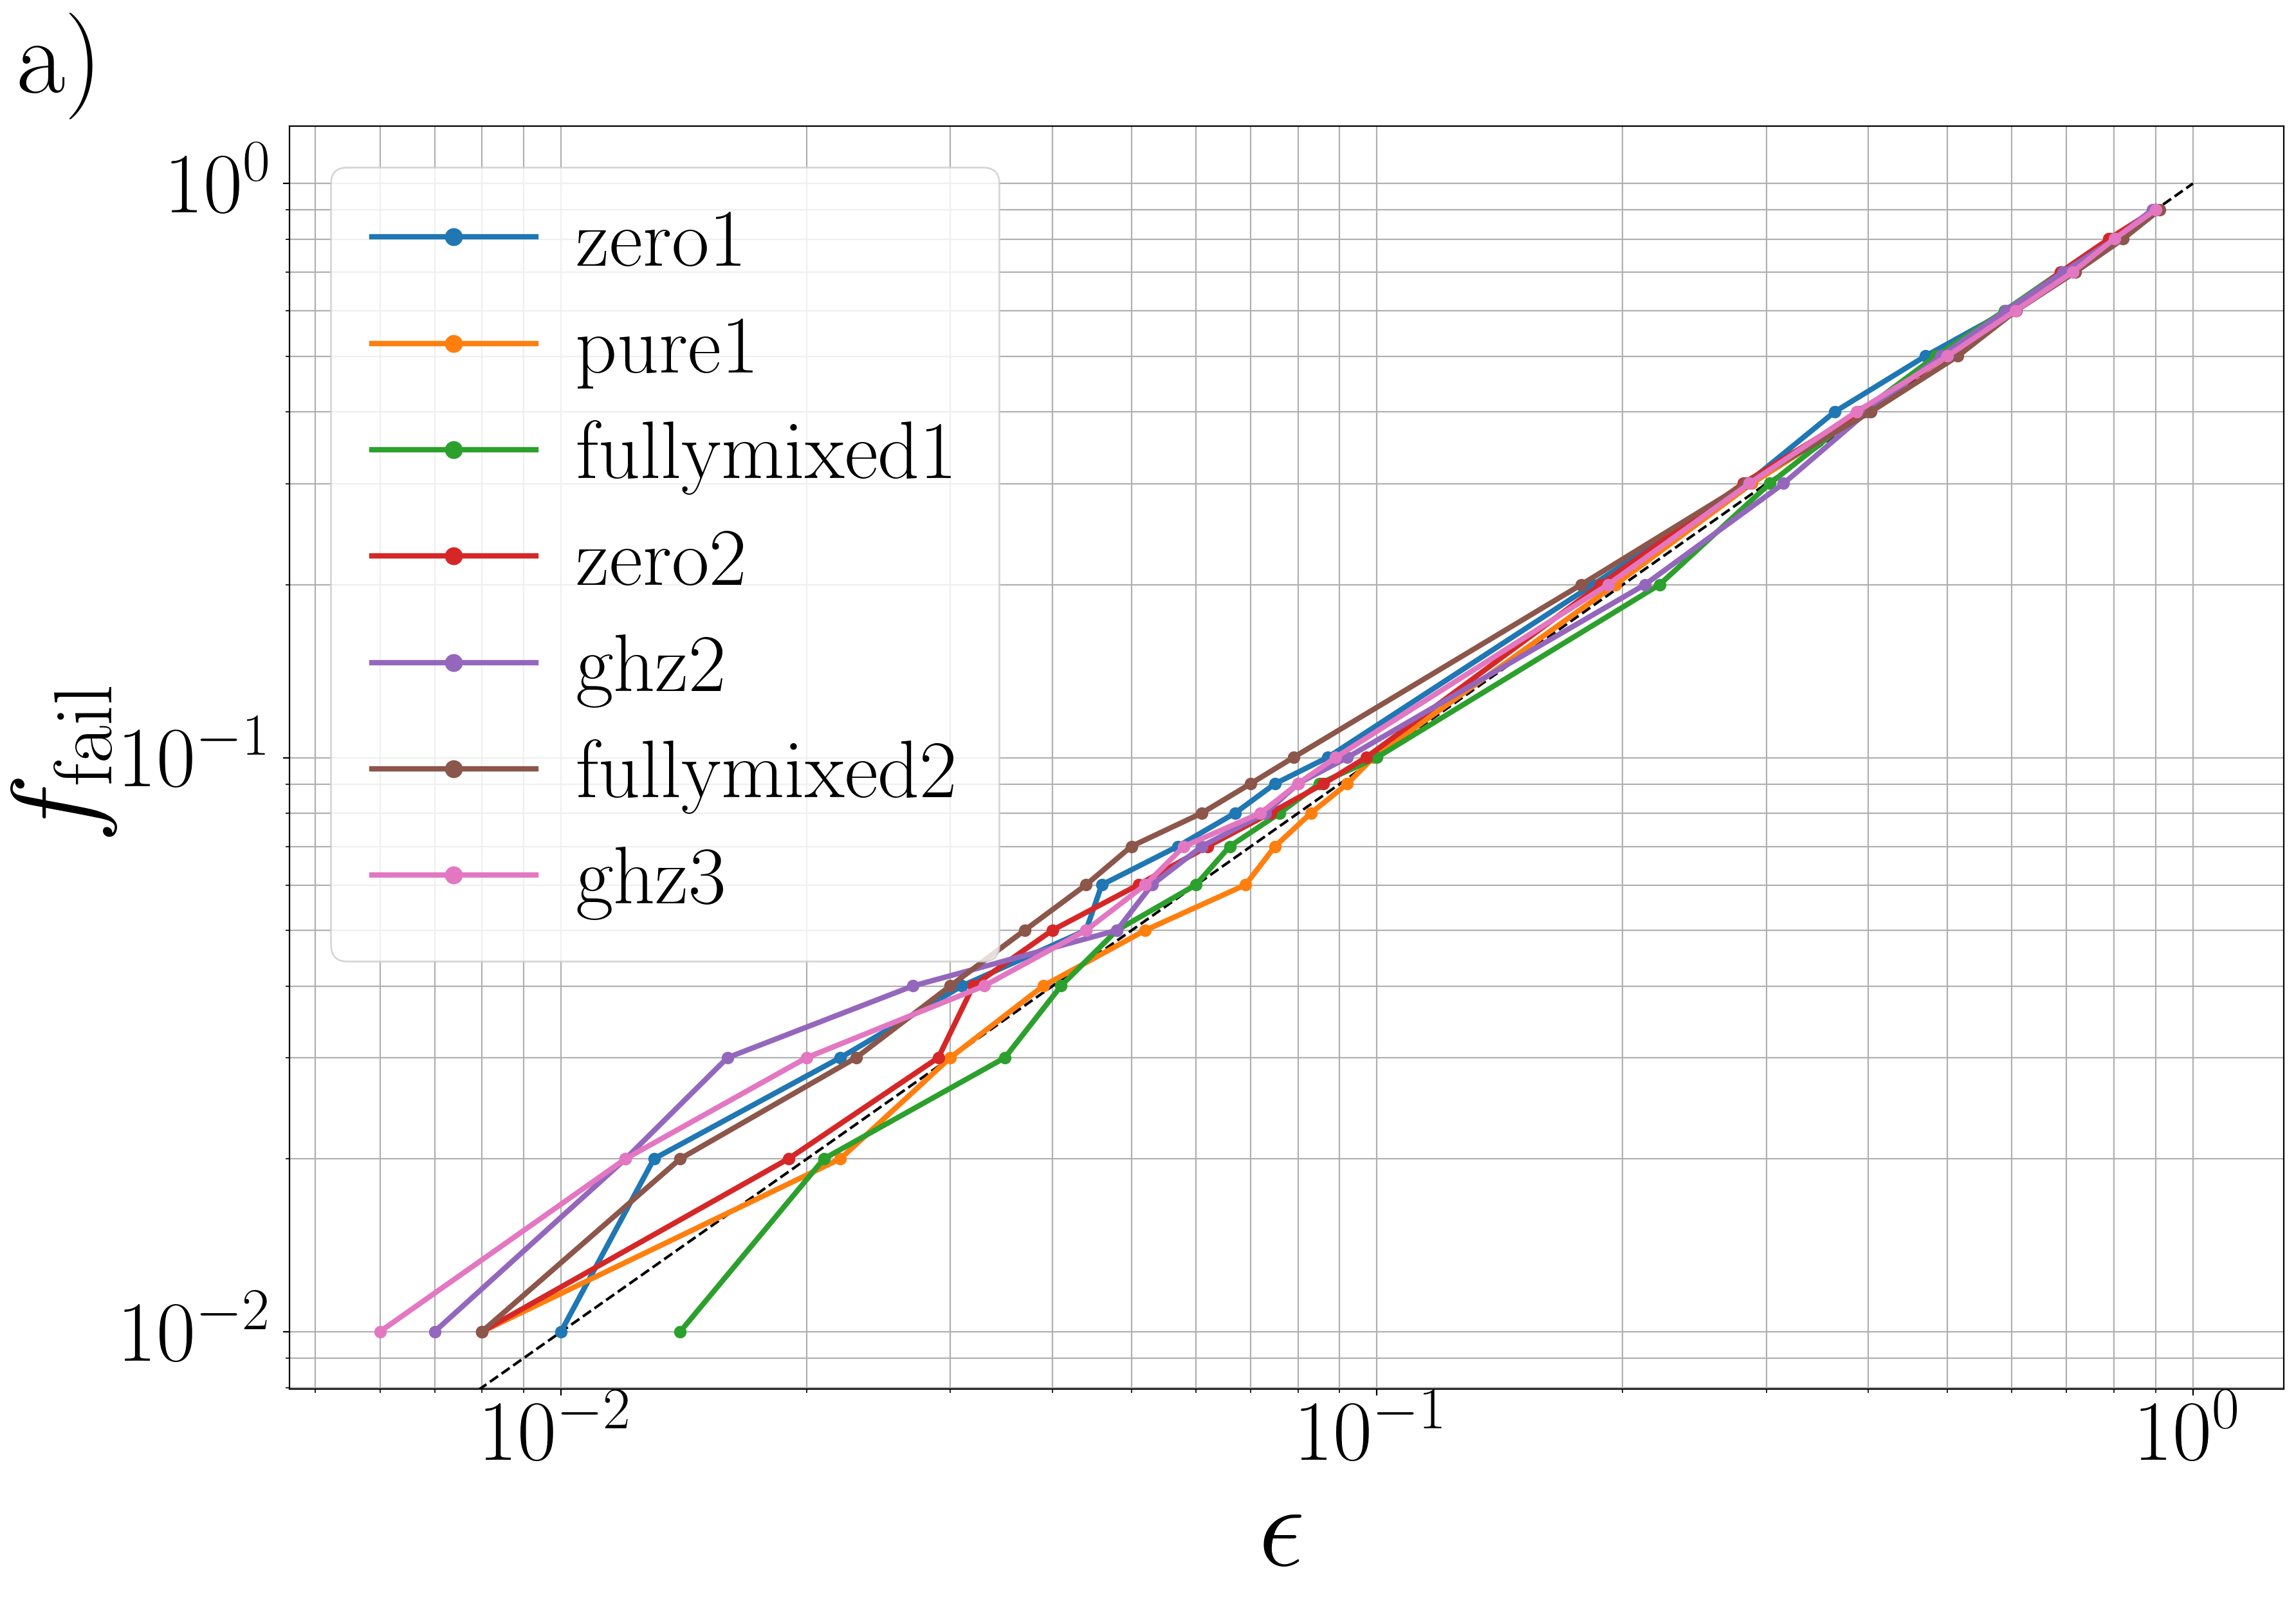

In [8]:
# conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
indices = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1000, 100)))
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for name, results in states_results.items():
    plt.plot(np.asarray(results)[indices], np.linspace(0, 1, N_POINTS)[indices], 
             '-o', label=name, linewidth=3)
plt.legend()
plt.figtext(0.02, 0.9, "a)")

In [19]:
0.05 * 0.95 / np.sqrt(1000)

0.0015020818885799802

In [56]:
N_REPEATS = 1000
N_POINTS = 1000

processes_results = defaultdict(list)

for i in range(0, 5):
    process = processes.iloc[i]
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.ProcessTomograph(process['process'], input_states='proj4')
        tmg.experiment(process['n_meas'], povm=process['povm'])
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        process_hat = tmg.point_estimate(cptp=False, states_physical=False)
        distance_hat = qp.hs_dst(process_hat.choi, process['process'].choi)
        ub_cls = np.where(distance_hat < dist)[0]
        epsilon = 1 - np.where(distance_hat < dist)[0][0] / N_POINTS if len(ub_cls) != 0 else 0
        processes_results[process['name']].append(epsilon)
    processes_results[process['name']].sort()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.02, 0.9, 'a)')

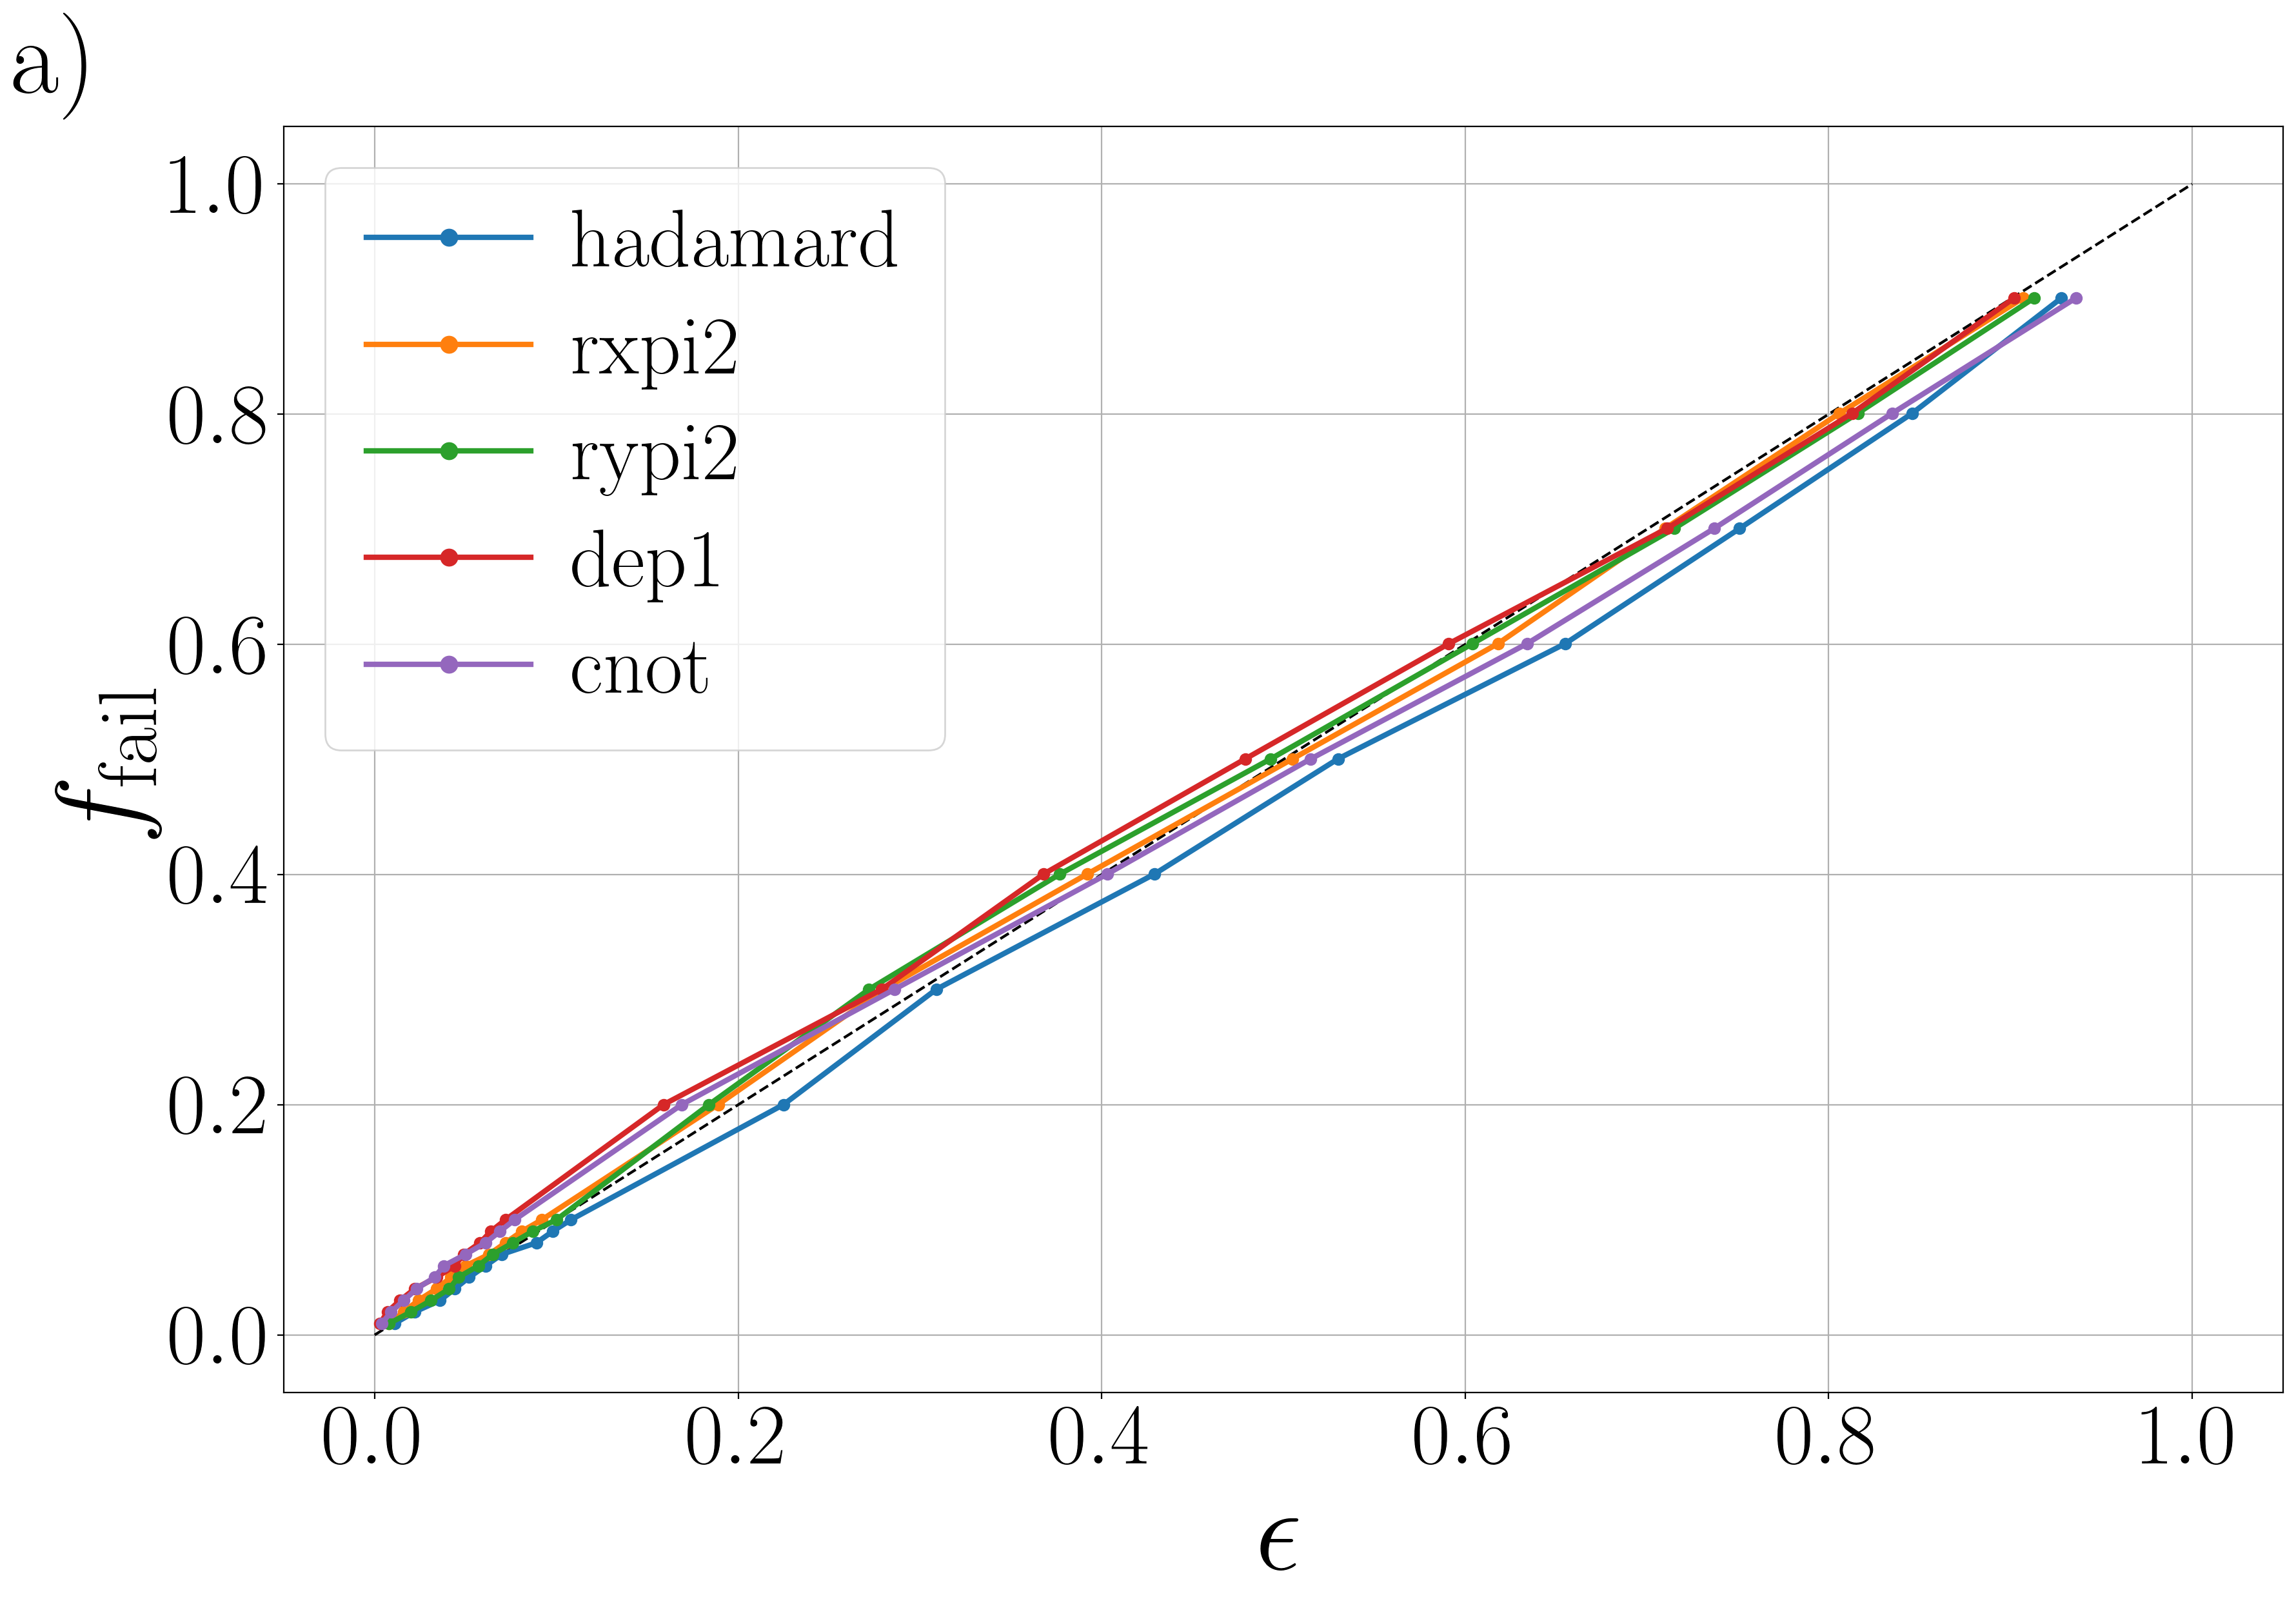

In [55]:
# conf_levels = np.concatenate((np.arange(0.1, 0.9, 0.1), np.arange(0.9, 1, 0.01)))
indices = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1000, 100)))
plt.figure(figsize=(20, 13), dpi=200)
plt.xlabel('$\\epsilon$')
plt.ylabel('$f_{\\rm fail}$')
# plt.xscale('log')
# plt.yscale('log')
plt.grid(which='both')
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--k')
for name, results in processes_results.items():
    plt.plot(np.asarray(results)[indices], np.linspace(0, 1, N_POINTS)[indices], 
             '-o', label=name, linewidth=3)
plt.legend()
plt.figtext(0.02, 0.9, "a)")

In [17]:
N_REPEATS = 1000
N_POINTS = 1000
CONFIDENCE_LEVELS = [0.5, 0.75, 0.9, 0.95, 0.99]

processes_results = defaultdict(list)

for _, process in processes.iterrows()[:4]:
    results = Counter()
    for _ in tqdm(range(N_REPEATS)):
        tmg = qp.ProcessTomograph(process['process'])
        tmg.experiment(process['n_meas'], povm=process['povm'])
        interval = qp.MomentInterval(tmg, n_points=N_POINTS)
        dist, CLs = interval()
        process_hat = tmg.point_estimate(cptp=False)
        distance_hat = qp.hs_dst(process_hat.choi, process['process'].choi)
        for cl in CONFIDENCE_LEVELS:
            if distance_hat < dist[int(cl * N_POINTS)]:
                results[cl] += 1
    
    processes_results['name'].append(process['name'])
    for key, value in results.items():
        processes_results[key].append(value / N_REPEATS)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
pd.DataFrame(processes_results)

,name,0.5,0.75,0.9,0.95,0.99
0,hadamard,0.508,0.730,0.859,0.916,0.971
1,rxpi2,0.547,0.752,0.875,0.930,0.977
2,rypi2,0.525,0.747,0.873,0.917,0.969
3,dep1,0.556,0.732,0.861,0.919,0.971
